In [2]:
using Yao, BitBasis, CuYao, YaoExtensions, Yao.AD, Zygote, YaoPlots
using LinearAlgebra, Statistics, Random, StatsBase
using NPZ, JLD2, FileIO, Printf, BenchmarkTools, MAT, Plots, PyPlot
using Flux: batch, Flux
using CUDA
using ArgParse
using Distributions
using Dates

# check the data

In [3]:
var1 = matread("train_step=20_row_idx=9.mat")

Dict{String, Any} with 5 entries:
  "thetas"          => [0.391994 0.148226 … -0.546227 -0.496874; 0.962994 1.684…
  "P0_corr_test"    => [0.49075 0.609424 … 0.35288 0.281326]
  "batch_idx_test"  => [3.0 7.0 … 96.0 98.0]
  "P0_corr_train"   => [0.656545 0.433159 … 0.382548 0.569284]
  "batch_idx_train" => [25.0 33.0 … 453.0 456.0]

In [4]:
var1["batch_idx_train"]

1×20 Matrix{Float64}:
 25.0  33.0  50.0  65.0  90.0  123.0  …  386.0  402.0  448.0  453.0  456.0

In [5]:
var3 = matread("model_medical_20220130.mat")

Dict{String, Any} with 7 entries:
  "theta"       => [0.395497, 0.797844, 0.751559, 0.656747, 0.345, 0.0158026, 0…
  "INI_theta"   => [0.395497, 0.797844, 0.751559, 0.656747, 0.345, 0.0158026, 0…
  "y_train"     => [1.0 0.0; 1.0 0.0; … ; 0.0 1.0; 0.0 1.0]
  "predictions" => [0.717965 0.282035 1.0 0.0; 0.697209 0.302791 1.0 0.0; … ; 0…
  "x_train"     => [3.24523 3.19118 … 3.14159 3.14159; 3.23407 3.19047 … 3.1415…
  "x_test"      => [3.14159 3.14159 … 3.14159 3.14159; 3.14159 3.14159 … 3.1415…
  "y_test"      => [0.0 1.0; 0.0 1.0; … ; 0.0 1.0; 0.0 1.0]

In [6]:
x_train = var3["x_train"]
y_train = var3["y_train"]
x_test = var3["x_test"]
y_test = var3["y_test"]
nbit = 10;

In [7]:
var1["batch_idx_train"]

1×20 Matrix{Float64}:
 25.0  33.0  50.0  65.0  90.0  123.0  …  386.0  402.0  448.0  453.0  456.0

In [9]:
trained_params = reshape(var1["thetas"],(260,));

# check the correspondence between the numerical simulation and physical experiments

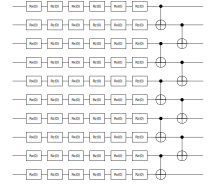

In [10]:
RX_layer(nbit::Int64) = chain(put(nbit, i => Rx(0)) for i in 1:nbit)
RZ_layer(nbit::Int64) = chain(put(nbit, i => Rz(0)) for i in 1:nbit)

RX_layer(nbit::Int64) = chain(put(nbit, i => Rx(0)) for i in 1:nbit)
RZ_layer(nbit::Int64) = chain(put(nbit, i => Rz(0)) for i in 1:nbit)
E_layer(nbit::Int64) = 
(nbit%2 == 0) ? 
chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-1),chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-2)) : 
chain(chain(nbit,control(i,i+1=>X) for i in 1:2:nbit-2),chain(nbit,control(i,i+1=>X) for i in 2:2:nbit-1))

big_block(nbit::Int64) = chain(RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit),RZ_layer(nbit),E_layer(nbit))
big_block2(nbit::Int64) = chain(RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit),RZ_layer(nbit),RX_layer(nbit),RZ_layer(nbit),E_layer(nbit))
YaoPlots.plot(big_block(nbit))

nparameters(circuit) = 260


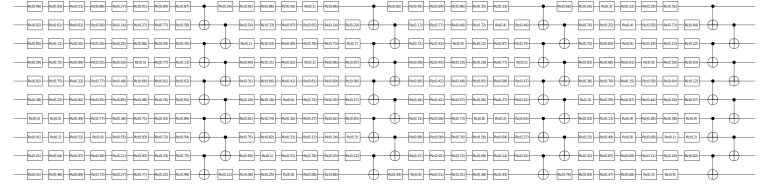

In [11]:
num_bigblock = 3
num_bigblock2 = 1
num_params_bigblock = nparameters(big_block(nbit))
num_x_bigblock = 60
circuit = chain(chain(big_block2(nbit) for i in 1:num_bigblock2),chain(big_block(nbit) for i in 1:num_bigblock))
@show nparameters(circuit);
dispatch!(circuit, :random);
YaoPlots.plot(circuit)

In [12]:
pos_ = 5
op0 = put(nbit, pos_=>0.5*(I2+Z))
op1 = put(nbit, pos_=>0.5*(I2-Z));
num_train = 500
num_test = 100

100

In [13]:
ini_params = trained_params
train_cir = [chain(chain(big_block2(nbit) for i in 1:num_bigblock2),chain(big_block(nbit) for i in 1:num_bigblock)) for i in 1:num_train]
test_cir = [chain(chain(big_block2(nbit) for i in 1:num_bigblock2),chain(big_block(nbit) for i in 1:num_bigblock)) for i in 1:num_test];
for i in 1:num_train
    dispatch!(train_cir[i], x_train[:,i]+ini_params)
end
for i in 1:num_test
    dispatch!(test_cir[i], x_test[:,i]+ini_params)
end

In [15]:
function pred(nbit,circuit,y_batch,batch_size)
    rdm = batch([density_matrix(focus!(zero_state(nbit) |> circuit[i], (pos_))).state for i in 1:batch_size])[:,:,1,:]
    q_ = zeros(batch_size,2);
    for i=1:batch_size
        q_[i,:] = diag(rdm[:,:,i]) |> real
    end
    q_
end
kk = hcat(pred(nbit,train_cir,y_train,num_train),y_train);

# The theory agrees well with the experiment as shown below

In [16]:
hcat(var1["P0_corr_train"][:],1 .- var1["P0_corr_train"][:],kk[Vector{Int64}(var1["batch_idx_train"][:]).+1,1:2],kk[Vector{Int64}(var1["batch_idx_train"][:]).+1,3:4])

20×6 Matrix{Float64}:
 0.656545  0.343455  0.711179  0.288821  1.0  0.0
 0.433159  0.566841  0.429744  0.570256  0.0  1.0
 0.623386  0.376614  0.708578  0.291422  1.0  0.0
 0.518674  0.481326  0.625311  0.374689  1.0  0.0
 0.372077  0.627923  0.306408  0.693592  0.0  1.0
 0.590227  0.409773  0.658691  0.341309  1.0  0.0
 0.539616  0.460384  0.516192  0.483808  0.0  1.0
 0.626876  0.373124  0.701116  0.298884  1.0  0.0
 0.363351  0.636649  0.304862  0.695138  0.0  1.0
 0.53438   0.46562   0.578735  0.421265  1.0  0.0
 0.539616  0.460384  0.546021  0.453979  1.0  0.0
 0.304014  0.695986  0.212379  0.787621  0.0  1.0
 0.639092  0.360908  0.683897  0.316103  1.0  0.0
 0.338918  0.661082  0.272646  0.727354  0.0  1.0
 0.567539  0.432461  0.609064  0.390936  1.0  0.0
 0.660035  0.339965  0.75623   0.24377   1.0  0.0
 0.583246  0.416754  0.605242  0.394758  1.0  0.0
 0.628621  0.371379  0.631812  0.368188  1.0  0.0
 0.382548  0.617452  0.328272  0.671728  0.0  1.0
 0.569284  0.430716  0.60401

# generating adversarial examples

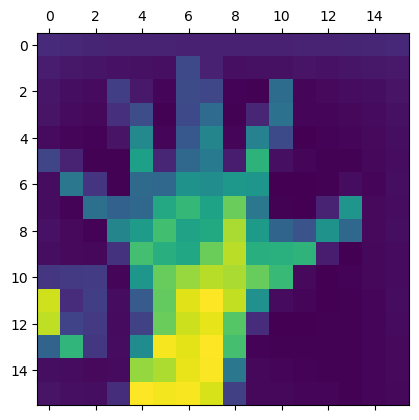

PyObject <matplotlib.image.AxesImage object at 0x7f3cea9de670>

In [17]:
j = 3
i = Int64(var1["batch_idx_train"][j]+1)
a = x_train[1:256,i]
b = y_train[i,1]
c = reshape(a,(16,16))
matshow(c)

In [18]:
rr = (sign.(x_train[:,i] .- pi .- 0.05) .+ 1)/2;
dispatch!(circuit, x_train[:,i]+trained_params)
@show real(expect(op0, zero_state(nbit)=>circuit)),var1["P0_corr_train"][j] # 这两个数分别是理论和实验的预测概率
initial_model_params = trained_params
legi_sample_hand = x_train[:,i]

x_adv = x_train[:,i]
optim = Flux.ADAM(0.01)

for i in 1:7
    grad = expect'(op0, zero_state(nbit)=>circuit)[2]
    ########### 
    grad = rr .* grad
    ###########
    x_adv = Flux.Optimise.update!(optim, x_adv, (grad)); 
    dispatch!(circuit,x_adv+trained_params)
    @show expect(op0, zero_state(nbit)=>circuit)
end
adv_sample_hand = copy(x_adv);

(real(expect(op0, zero_state(nbit) => circuit)), (var1["P0_corr_train"])[j]) = (0.7085782963915472, 0.6233856893542757)
expect(op0, zero_state(nbit) => circuit) = 0.6632271504859439 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.6157566568872763 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.5671300101774841 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.5182529037715885 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.4700260394444375 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.42327949153405453 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.3787836293377975 + 0.0im


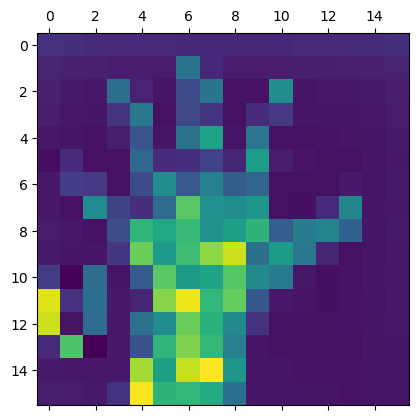

PyObject <matplotlib.image.AxesImage object at 0x7f3d35d76910>

In [21]:
a = real(x_adv[1:256])
c = reshape(a,(16,16))
matshow(c)

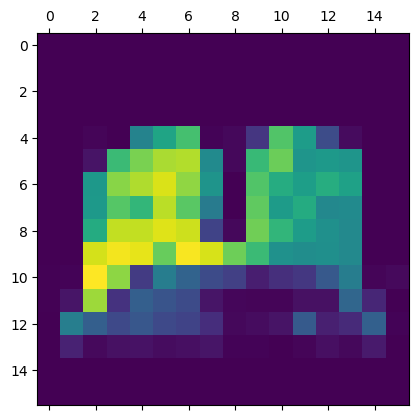

PyObject <matplotlib.image.AxesImage object at 0x7f3d35d5cc40>

In [22]:
j = 9
i = Int64(var1["batch_idx_train"][j]+1)
a = x_train[1:256,i]
b = y_train[i,1]
c = reshape(a,(16,16))
matshow(c)

In [23]:
rr = (sign.(x_train[:,i] .- pi .- 0.05) .+ 1)/2
dispatch!(circuit, x_train[:,i]+trained_params)
@show real(expect(op0, zero_state(nbit)=>circuit)),var1["P0_corr_train"][j] # 这两个数分别是理论和实验的预测概率
legi_sample_breast = x_train[:,i]
x_adv = x_train[:,i]
optim = Flux.ADAM(0.01)

for i in 1:10
    grad = expect'(op0, zero_state(nbit)=>circuit)[2]
    ########### 这两行限制了扰动区域
    grad = rr .* grad
    ###########
    x_adv = Flux.Optimise.update!(optim, x_adv, -(grad)); 
    dispatch!(circuit,x_adv+trained_params)
    @show expect(op0, zero_state(nbit)=>circuit)
end
adv_sample_breast = copy(x_adv);

(real(expect(op0, zero_state(nbit) => circuit)), (var1["P0_corr_train"])[j]) = (0.30486206820652584, 0.3633507853403141)
expect(op0, zero_state(nbit) => circuit) = 0.33389777414410116 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.36429071738175034 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.39564795144648013 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.42753773362670827 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.45950806258939786 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.4910994255741073 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.5218540795215526 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.5513235269691813 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.5790807571403053 + 0.0im
expect(op0, zero_state(nbit) => circuit) = 0.6047388340737985 + 0.0im


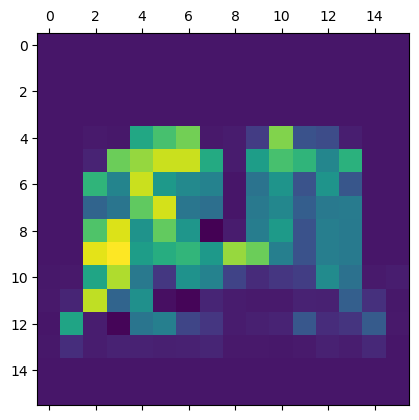

PyObject <matplotlib.image.AxesImage object at 0x7f3cdea7b070>

In [24]:
# 从上面的梯度下降对抗攻击可以看出，分类器将会把下图分类到“9”
a = real(x_adv[1:256])
c = reshape(a,(16,16))
matshow(c)

# Now, we show how the adversarial training can defend against these attacks

# 1. import the adversarial trained model from physical experiments

In [38]:
var1_ = matread("train_step=30_row_idx=0.mat")

Dict{String, Any} with 5 entries:
  "thetas"          => [-0.112438 -0.099532 … -0.745999 -0.674739; 0.871611 0.9…
  "P0_corr_test"    => [0.301312 0.310174 … 0.391705 0.641616]
  "batch_idx_test"  => [0.0 1.0 … 190.0 197.0]
  "P0_corr_train"   => [0.38816 0.547678 … 0.467919 0.650479]
  "batch_idx_train" => [21.0 22.0 … 931.0 992.0]

In [39]:
adv_trained_model_params = reshape(var1_["thetas"],(260,));

# 2. test the prediction of
## a. trained model with a legitimate sample
## b. trained model with an adversarial sample
## c. adversarially trained model with an adversarial sample

# we can see the successful defense

legitimate sample, trained model: correct => prediction = 0.7085782963915472 + 0.0im
adversarial sample, trained model: incorrect => prediction = 0.3787836293377975 + 0.0im
adversarial sample, adversarially trained model: correct => prediction = 0.6915592706934479 + 0.0im


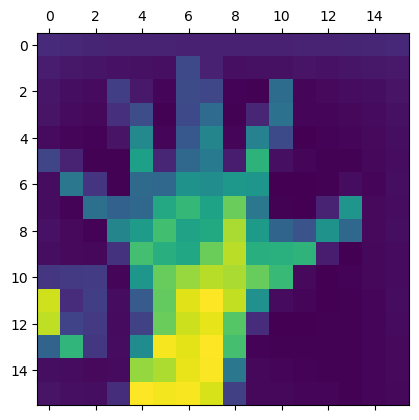

0.6915592706934479 + 0.0im

In [42]:
j = 3
i = Int64(var1["batch_idx_train"][j]+1)
a = x_train[1:256,i]
b = y_train[i,1]
c = reshape(a,(16,16))
x_adv = adv_sample_hand
matshow(c)
dispatch!(circuit, x_train[:,i]+trained_params)
print("legitimate sample, trained model: correct => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction
dispatch!(circuit, x_adv+trained_params)
print("adversarial sample, trained model: incorrect => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction
dispatch!(circuit,x_adv+reshape(var1_["thetas"],(260,)))
print("adversarial sample, adversarially trained model: correct => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction

legitimate sample, trained model: correct => prediction = 0.30486206820652584 + 0.0im
adversarial sample, trained model: incorrect => prediction = 0.6047388340737985 + 0.0im
adversarial sample, adversarially trained model: correct => prediction = 0.24965059476315904 + 0.0im


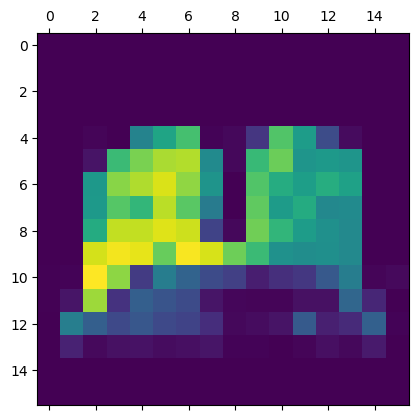

In [44]:
j = 9
i = Int64(var1["batch_idx_train"][j]+1)
a = x_train[1:256,i]
b = y_train[i,1]
c = reshape(a,(16,16))
x_adv = adv_sample_breast
matshow(c)
dispatch!(circuit, x_train[:,i]+trained_params)
print("legitimate sample, trained model: correct => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction
dispatch!(circuit, x_adv+trained_params)
print("adversarial sample, trained model: incorrect => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction
dispatch!(circuit,x_adv+reshape(var1_["thetas"],(260,)))
print("adversarial sample, adversarially trained model: correct => ")
prediction = expect(op0, zero_state(nbit)=>circuit)
@show prediction;